## Library Imports

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

# Setting seed for reproducibility
np.random.seed(42)

c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\skl2onnx\algebra\onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\skl2onnx\algebra\automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
c:\Users\abhay\AppData\Local\Programs\Python\Python310\lib\site-packages\jinja2\environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


## Load Dataset

In [3]:
# Removing Samples where data had to be discarded due to some collection errors.
remove = ['P1', 'P11','P2', 'P22', 'P25', 'P37', 'P4', 'P47', 'P48', 'P49','P50', 'P54', 'P56', 'P59','P16', 'P24', 'P67', 'P68', 'P72','P74','P75','P30','P51','P58']

# Load Spiro Data
data = np.load('../Feature Extractor/Data/Autoclip_3000_5000_N95_FEATURES.npy',allow_pickle=True)
print("data before removing columns",data.shape)
# data = data[~np.isin(data[:,0],remove)]

# Bifurcate into X and y
X = pd.DataFrame(data[:,1:-2],dtype=float)
y_FEV1= pd.DataFrame(data[:,-2],dtype=float)
y_FVC = pd.DataFrame(data[:,-1],dtype=float)

print("data after removing columns",X.shape,y_FEV1.shape,y_FVC.shape)

data before removing columns (72, 1028)
data after removing columns (72, 1025) (72, 1) (72, 1)


## Random Forest Trainer Function

In [4]:
def train_RF(RF,X,y):
        
    # Total number of the splits
    tot = len(X)
    
    # Instantiating Leave_One_Out split function.
    loo = LeaveOneOut()

    prog        = 0     # Progress counter
    y_GT        = []    # Ground truth
    y_PT        = []    # Predicted value

    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
    print("Training Random Forest Regressor")

    # For every split obtained by Leave_One_Out split function.
    for i,(train_index, test_index) in enumerate(loo.split(X)):
        
        # To show some sort of progress.
        prog = prog + 1
        print("\tLOOCV Fold no  : {0}/{1}".format(prog,tot),end = '\r')

        # Test-train split for the fold.
        X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
        y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]
        
        # Training new Random Forest ensemble.
        RF.fit(X_Train, np.ravel(y_Train))
        pred = RF.predict(X_Test) 
        print("x test shape",X_Test.shape)

        # Storing the values of Ground truth and Predicted value for future use.
        y_GT.append(y_Test.iloc[0,0])
        y_PT.append(pred[0]) 


    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
    print("\tRandom forest metrics : ")
    print("\t\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
    print("\t\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
    print("\t\tMean Square Error : " , mean_squared_error(y_GT,y_PT,squared=False))
    print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")

    y_err = abs(np.array(y_GT) - np.array(y_PT))/np.array(y_GT)

    return y_err

# FEV1

In [5]:
# Instantiating Random forest Regressor.
rf_fev1 = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='absolute_error',
                                  n_estimators=100,  max_features=1.0, max_depth=None, 
                                  min_samples_leaf=1, min_samples_split=2 ,random_state=42)

y_err_FEV1 =  train_RF(rf_fev1,X,y_FEV1)

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Training Random Forest Regressor
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 10

# FVC

In [6]:
# Instantiating Random forrest Regressor.
rf_fvc = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error',
                                  n_estimators=100,  max_features=1.0, max_depth=None,  
                                  min_samples_leaf=1, min_samples_split=2 ,random_state=42)

y_err_FVC =  train_RF(rf_fvc,X,y_FVC)

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Training Random Forest Regressor
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 1025)2
x test shape (1, 10

## Visualize the errors in the predictions

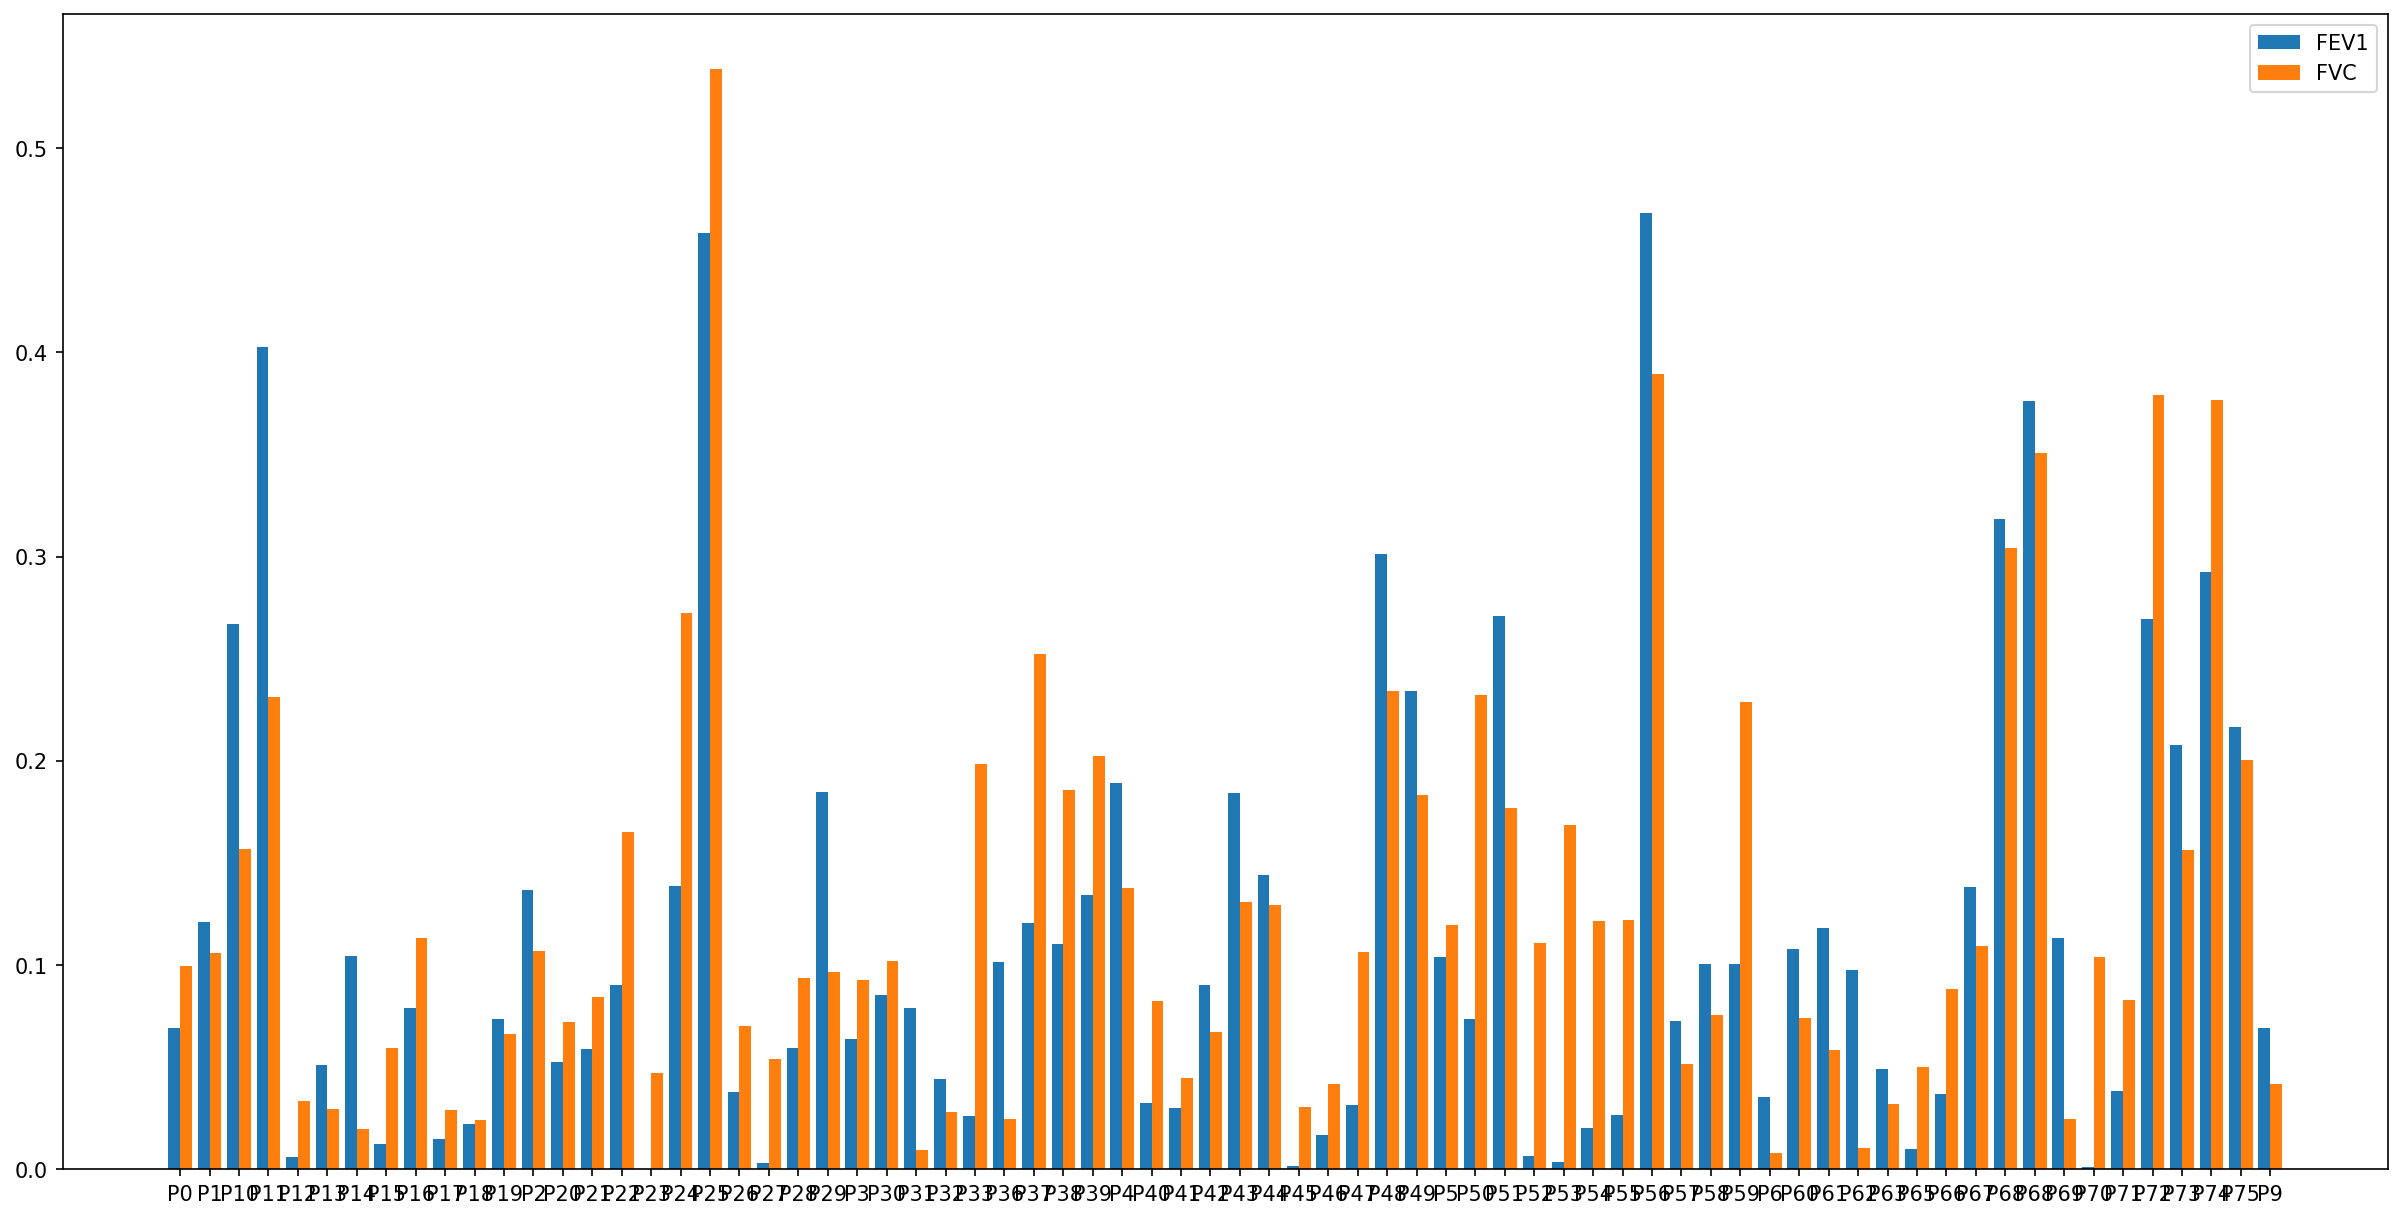

In [7]:
plt.figure(figsize=(20,10),dpi=150)
plt.bar([i-0.2 for i in range(len(y_err_FEV1))],y_err_FEV1,width=0.4,label='FEV1')
plt.bar([i+0.2 for i in range(len(y_err_FVC))],y_err_FVC,width=0.4,label='FVC')
plt.xticks([i for i in range(len(y_err_FVC))],[data[i][0] for i in range(len(y_err_FEV1))])
plt.legend()
plt.show()

In [8]:
# Specify an initial type for the model ( similar to input shape for the model )
# the shape of input of out model is 1* 262
initial_type = [ 
    ( 'audio_features_array' , FloatTensorType( [1,1025] ) ) 
]

converted_model = convert_sklearn( rf_fev1 , initial_types=initial_type )
with open( "rf_fev1.onnx", "wb" ) as f:
    f.write( converted_model.SerializeToString() )
print("Model saved as rf_fev1.onnx")



Model saved as rf_fev1.onnx


## Exporting the FVC Model


In [9]:
fvc_converted = convert_sklearn( rf_fvc , initial_types=initial_type )
with open( "rf_fvc.onnx", "wb" ) as f:
    f.write( fvc_converted.SerializeToString() )
print("Model saved as rf_fvc.onnx")

Model saved as rf_fvc.onnx


predict for first 5

In [10]:
print(y_FEV1.shape)
for i in range(0,data.shape[0]):
    print("for ",data[i][0])
    print("predicted fev1 for ",i+1," is: ",rf_fev1.predict(X[i:i+1])," and actual is: ",y_FEV1[0][i])
    print("predicted fvc for ",i+1,rf_fvc.predict(X[i:i+1]), " and actual is fvc",y_FVC[0][i])

(72, 1)
for  P0
predicted fev1 for  1  is:  [2.9299]  and actual is:  2.89
predicted fvc for  1 [3.0895]  and actual is fvc 3.0
for  P1
predicted fev1 for  2  is:  [2.8086]  and actual is:  2.7
predicted fvc for  2 [3.6326]  and actual is fvc 3.76
for  P10
predicted fev1 for  3  is:  [3.049]  and actual is:  3.36
predicted fvc for  3 [3.3787]  and actual is fvc 3.6
for  P11
predicted fev1 for  4  is:  [2.3359]  and actual is:  2.04
predicted fvc for  4 [3.5792]  and actual is fvc 3.94
for  P12
predicted fev1 for  5  is:  [2.7531]  and actual is:  2.78
predicted fvc for  5 [3.1586]  and actual is fvc 3.1
for  P13
predicted fev1 for  6  is:  [2.6865]  and actual is:  2.78
predicted fvc for  6 [2.8652]  and actual is fvc 2.89
for  P14
predicted fev1 for  7  is:  [2.6397]  and actual is:  2.78
predicted fvc for  7 [2.8917]  and actual is fvc 2.89
for  P15
predicted fev1 for  8  is:  [3.1033]  and actual is:  3.16
predicted fvc for  8 [3.2623]  and actual is fvc 3.2
for  P16
predicted fev1 

In [13]:
x = pd.read_csv("../Feature Extractor/Data/Test_stft_phone/a_1688688386674.csv")
x=np.complex_(x)
x[:, ~np.isnan(x).any(axis=0)]
np.set_printoptions(threshold=sys.maxsize)
x

array([[ 8.95906346e-03+3.92176255e-18j, -7.60780862e-04+1.86561152e-02j,
        -1.40812993e-02-2.02919106e-02j,  3.19989183e-03+8.34856711e-03j,
        -9.05228961e-03-8.58710539e-03j, -1.17138537e-02+2.62100853e-03j,
        -2.98086952e-03-1.36784514e-03j, -1.39623227e-02+9.89570045e-03j,
         1.37874217e-02-3.73089827e-05j, -1.62889267e-02+1.14474349e-02j,
         1.45375339e-02-2.40759114e-03j, -1.37348025e-02-7.76251375e-03j,
         1.63597888e-02+1.31361689e-03j, -9.80086353e-03-1.29486342e-02j,
        -2.12833716e-03+9.48142808e-03j,  3.58762954e-03-1.24840655e-02j,
        -2.18877134e-02+1.04737785e-02j,  9.60889377e-03-5.92563555e-03j,
        -1.64105936e-02-1.18087880e-03j,  6.52444395e-03+3.91903416e-03j,
         1.48238537e-03-8.95926037e-03j, -1.96662036e-02-5.40526451e-03j,
         1.07873343e-02+7.74096131e-03j, -1.06379525e-02-1.54193918e-02j,
         4.64381244e-03+7.58986392e-03j,  4.39838646e-02+1.36923967e-03j,
        -8.31720359e-03+1.01592011e-02